In [87]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, Column, vstack

plt.rc('font', size=20)
plt.rc('text', usetex=True)

In [412]:
n_e = 1e7
log_T = 4.0

In [413]:
# Import A_ij table
Atable = Table.read('Atable_Storey2016.txt', format='ascii.fixed_width')
# Import energy level table
energy_level = Table.read('energy_levels_lowest15.txt', format='ascii')
energy_level.add_column(Column(data=energy_level['Jn'] / energy_level['Jd'], name='J', dtype='float64'))

# Import Y_ij table
Ytable = Table.read('Tave_collision_strength.txt', format='ascii')
temp_set = np.arange(2.0, 4.6, 0.2)
for i in range(len(temp_set)):
    Ytable['col' + str(i + 3)].name = str(round(temp_set[i], 1))
Ytable['col1'].name = 'i'
Ytable['col2'].name = 'j'

## The equation should be $(j>i)$:
\begin{equation}
\frac{\mathrm{d}n_i}{\mathrm{d}t} = A_{ij}n_{j} + P_{ij} n_e n_j - Q_{ji} n_e n_i = 0,
\end{equation}
in which $$A_{ij} = A_{j\to i},$$ $$P_{ij} = q(j\to i ),$$ $$Q_{ji} = q(i \to j).$$

# $A_{ij}$ is $A_{j\to i}$

Text(0,0.5,'$i$')

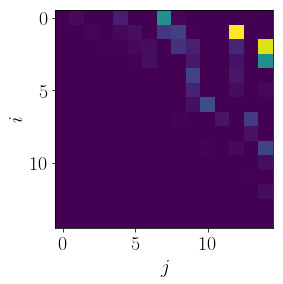

In [414]:
A_mat = np.zeros([15,15]) 
for row in Atable:
    A_mat[row['i']-1, row['j']-1] = row['Aji']

plt.imshow(A_mat)
plt.xlabel(r'$j$')
plt.ylabel(r'$i$')

### $E_{ij}$

Text(0,0.5,'$i$')

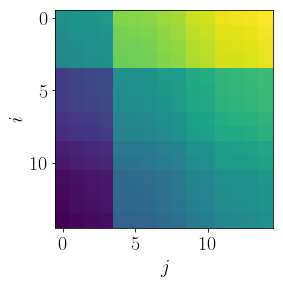

In [415]:
# E_ij: transition energy from i to j (>0 for excitation)
E_mat = np.zeros([15, 15])
for i in range(15):
    for j in range(15):
        E_mat[i, j] = energy_level[j]['Eexp'] - energy_level[i]['Eexp']
# Now convert the unit from cm^{-1} to eV
E_mat = 4.1357*1e-15 * 3 * 1e10 * E_mat
plt.imshow(E_mat)
plt.xlabel(r'$j$')
plt.ylabel(r'$i$')

### $Y_{ij}$

Text(0,0.5,'$i$')

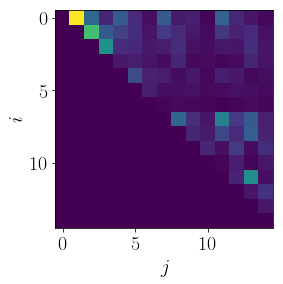

In [417]:
Y_mat = np.zeros([15,15]) 
for row in Ytable:
    Y_mat[row['i']-1, row['j']-1] = row[str(log_T)]
    
Y_mat = 26**2 * Y_mat
plt.imshow(Y_mat)
plt.xlabel(r'$j$')
plt.ylabel(r'$i$')

### $\omega_i$

In [418]:
omega = np.zeros(15)
for row in energy_level:
    omega[row['index'] - 1] = 2*row['J'] + 1

# Now we construct the collision excitation coefficient matrix $Q$. In this matrix, $Q_{ji}$ is $q(i\to j)$, where $i<j$. Excite from $i$ to $j$

In [419]:
R = 2.1716*1e-8
I_inf = 33.5 # eV
k_B = 8.6173303*1e-5 # eV/Kelvin

kT = k_B * 10**(log_T)
C = R * np.sqrt(I_inf / kT)

Q = np.zeros([15, 15])
for i in range(15):
    for j in range(15):
        if i>= j:
            continue
        else:
            Q[j, i] = C * np.exp( - E_mat[i, j] / kT  ) * Y_mat[i, j] / omega[i]

Text(0,0.5,'$i$')

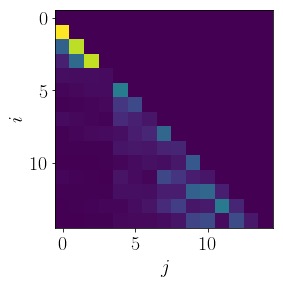

In [420]:
plt.imshow(Q)
plt.xlabel(r'$j$')
plt.ylabel(r'$i$')

# Now we construct the collision de-excitation coefficient matrix $P$. In this matrix, $P_{ij}$ is $q(j\to i)$, where $i<j$. Downward from $j$ to $i$.

In [421]:
P = np.zeros([15, 15])
for i in range(15):
    for j in range(15):
        if i>= j:
            continue
        else:
            P[i, j] = (omega[i]/ omega[j]) * np.exp( E_mat[i, j] / kT ) * Q[j, i]

Text(0,0.5,'$i$')

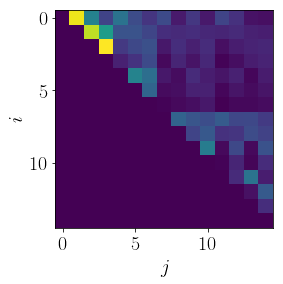

In [422]:
plt.imshow(P)
plt.xlabel(r'$j$')
plt.ylabel(r'$i$')

## The equation should be $(j>i)$:
\begin{equation}
\frac{\mathrm{d}n_i}{\mathrm{d}t} = \sum_j (A_{ij} + P_{ij} n_e) n_{j} - \sum_j Q_{ji} n_e n_i = 0,
\end{equation}
in which $$A_{ij} = A_{j\to i},$$ $$P_{ij} = q(j\to i ),$$ $$Q_{ji} = q(i \to j).$$

## Now our equation is:
\begin{equation}
[(\mathbf{A} + n_e\mathbf{P})\vec{n}]_i  - (\sum_j Q_{ji} n_e) n_i = 0
\end{equation}

Let $\mathbf{C} = diag\{{n_e\sum_j Q_{ji}}\}$ and $\mathbf{A}+ n_e\mathbf{P} = \mathbf{B}$. Then
$$(\mathbf{B} - \mathbf{C})\vec{n} = 0$$

In [423]:
C = n_e * np.diag(Q.sum(axis=0))

In [424]:
B = A_mat + n_e * P

Text(0,0.5,'$i$')

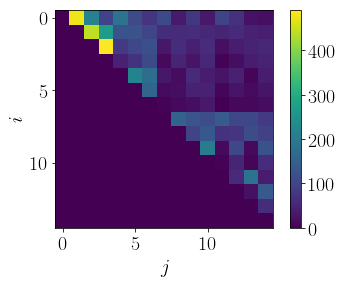

In [425]:
plt.imshow(n_e * P + A_mat)
plt.colorbar()
plt.xlabel(r'$j$')
plt.ylabel(r'$i$')

In [426]:
def null(A, eps=1e-15):
    u, s, vh = np.linalg.svd(A)
    null_space = np.compress(s <= eps, vh, axis=0)
    return null_space.T

In [427]:
v = null(n_e * P + A_mat - C) 
population = v / v[0]

In [428]:
population

array([[1.        ],
       [0.70874234],
       [0.48683044],
       [0.30566799],
       [0.06721188],
       [0.04337226],
       [0.02052835],
       [0.08670698],
       [0.06191469],
       [0.02182621],
       [0.00983053],
       [0.04550327],
       [0.02166952],
       [0.03421352],
       [0.01219121]])

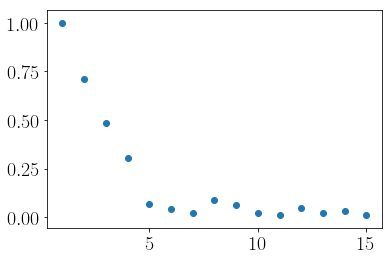

In [429]:
plt.scatter(energy_level['index'], population)

# Definition of $\rho$:
$$\rho\propto f_j A_{ij} |E_{ij}|$$

In [433]:
def cal_rho(j, i):
    return (population[j-1]  * A_mat[i-1, j-1] + n_e * P[i-1, j-1] * population[j-1] ) * abs(E_mat[i-1, j-1])

In [434]:
cal_rho(8, 1) / cal_rho(13, 2)

array([5.59070782])

# Sum it up:

In [436]:
n_e = 1e4
log_T = 4.0

In [437]:
def null(A, eps=1e-15):
    u, s, vh = np.linalg.svd(A)
    null_space = np.compress(s <= eps, vh, axis=0)
    return null_space.T
def cal_rho(j, i):
    return (population[j-1]  * A_mat[i-1, j-1] + n_e * P[i-1, j-1] * population[j-1] ) * abs(E_mat[i-1, j-1])

In [442]:
A_mat = np.zeros([15,15]) 
for row in Atable:
    A_mat[row['i']-1, row['j']-1] = row['Aji']
    
# E_ij: transition energy from i to j (>0 for excitation)
E_mat = np.zeros([15, 15])
for i in range(15):
    for j in range(15):
        E_mat[i, j] = energy_level[j]['Eexp'] - energy_level[i]['Eexp']
# Now convert the unit from cm^{-1} to eV
E_mat = 4.1357*1e-15 * 3 * 1e10 * E_mat

# Y
Y_mat = np.zeros([15,15]) 
for row in Ytable:
    Y_mat[row['i']-1, row['j']-1] = row[str(log_T)]
Y_mat = 26**2 * Y_mat
# omega
omega = np.zeros(15)
for row in energy_level:
    omega[row['index'] - 1] = 2*row['J'] + 1
    
# Q
R = 2.1716*1e-8
I_inf = 33.5 # eV
k_B = 8.6173303*1e-5 # eV/Kelvin

kT = k_B * 10**(log_T)
C = R * np.sqrt(I_inf / kT)

Q = np.zeros([15, 15])
for i in range(15):
    for j in range(15):
        if i>= j:
            continue
        else:
            Q[j, i] = C * np.exp( - E_mat[i, j] / kT  ) * Y_mat[i, j] / omega[i]
# P
P = np.zeros([15, 15])
for i in range(15):
    for j in range(15):
        if i>= j:
            continue
        else:
            P[i, j] = (omega[i]/ omega[j]) * np.exp( E_mat[i, j] / kT ) * Q[j, i]
            
# Solve
C = n_e * np.diag(Q.sum(axis=0))
v = null(n_e * P + A_mat - C) 
population = v / v[0]

In [443]:
population

array([[1.00000000e+00],
       [3.66845672e-02],
       [1.83392331e-03],
       [1.74466265e-04],
       [1.52039657e-06],
       [1.64560230e-06],
       [1.61381554e-07],
       [1.00579649e-08],
       [5.18599443e-10],
       [9.88550795e-10],
       [1.41476238e-11],
       [1.36125080e-11],
       [1.84119500e-11],
       [3.54965494e-13],
       [1.26479243e-13]])

In [444]:
cal_rho(2, 1) / cal_rho(8, 2) # should be 3.29

array([33614.46036065])